<img style="float: left;" src="resources/made.jpg" width="35%" height="35%">

# Академия MADE

## Семинар 5: сегментация
Преподаватель: Иван Карпухин, ведущий программист-исследователь команды машинного зрения.

<div style="clear:both;"></div>

В рамках семинар обучим U-Net модель для отделения предметов от фона на корпусе Pascal VOC.

Для выполнения работы нужны следующие пакеты (Python 3):
* opencv-python
* torch
* torchvision
* segmentation-models-pytorch

In [1]:
!pip install -q opencv-python torch torchvision segmentation-models-pytorch

In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/MADE/seminar8-segmentation"

/content/drive/MyDrive/Colab Notebooks/MADE/seminar8-segmentation


In [ ]:
import os
from zipfile import ZipFile

if not os.path.exists("checkpoints.zip"):
    raise FileNotFoundError(
        "Скачайте архив с обученными моделями: "
        "https://cloud.mail.ru/public/4XBu/vbfcjqzA6"
    )

with ZipFile("checkpoints.zip", "r") as zf:
    zf.extractall(".")

In [3]:
import random

import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torchvision
from torchvision.datasets import VOCSegmentation
import segmentation_models_pytorch as smp
from PIL import Image

import cvmade
import seminar

# Augmentations implementation from previous seminar:
from augmentations import (
    AffineAugmenter, BrightnessContrastAugmenter, BlurAugmenter,
    FlipAugmenter, RandomAugmentation
)

In [4]:
print("PyTorch version:", torch.__version__)

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(f"Using {device}.")

# If set to False, precomputed plots will be used instead of the real training
# (useful for demo purposes when there's no GPU):
TRAIN = False

# Training and visualization parameters:
TRAIN_KWARGS = {
    "plot": True,
    "train_plot_kwargs": {"c": "b"},
    "test_scatter_kwargs": {"c": "y", "s": 100, "zorder": 1e10},
    "use_cuda": USE_CUDA,
}

PyTorch version: 1.8.1+cu101
Using cuda.


In [5]:
def set_figure_size(figsize=(8, 6), dpi=120):
    plt.figure(figsize=figsize, dpi=dpi)

# Train U-Net on Pascal VOC

## Prepare dataset

Мы будем использовать корпус Pascal VOC.

In [6]:
DATA_ROOT = "."
VOC_YEAR = "2012"
LABELS = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted_plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

# If set to False, we separate objects from background (2 labels segmentation),
# otherwise we perform recognition for all object classes:
MULTICLASS = False

NUM_CLASSES = len(LABELS) if MULTICLASS else 2
print("Number of classes:", NUM_CLASSES)

Number of classes: 2


Mask values: {0, 10, 255}


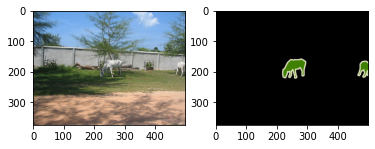

In [7]:
# Create temporary corpus for data preview:
valset_raw = VOCSegmentation(DATA_ROOT, VOC_YEAR, "val", download=False)  # Set to True when finished

image, mask = valset_raw[random.randint(0, len(valset_raw) - 1)]
print("Mask values:", set(np.array(mask).flatten().tolist()))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

Маска содержит номера классов для каждого пикселя. Имеется две специальные метки: 0 для фона и 255 для контура. Контур мы уберём.

In [8]:
for _ in range(5):
    i = random.randint(0, len(valset_raw) - 1)
    print(f"Image {i:05d} size: {valset_raw[i][0].size}.")

Image 01065 size: (375, 500).
Image 00276 size: (320, 212).
Image 00074 size: (350, 500).
Image 00826 size: (299, 500).
Image 00002 size: (500, 333).


В корпусе содержатся изображения разного размера. Можно пойти разными путями:
1. привести изображения к одному размеру масштабированием без сохранения пропорций;
2. привести изображения к одному размеру масштабированием с сохранением пропорций;
3. привести изображения к одному размеру, вырезая случайные части;
4. использовать модели, которые могут работать с разными размерами.

Заметим:
* Сеть U-Net способна обрабатывать изображения разных размеров, однако из изображений разного размера нельзя составить однородный тензор батча. Значит, изображения разного размера затруднят тренировку.

* Сеть U-Net является полностью свёрточной сетью без паддинга, а значит, каждый нейрон видит лишь часть картинки и не зависит от положения на изображении и близости к границе.

* Область внимания каждого нейрона задаётся в пикселях. Значит, чем меньше изображение, тем больше информации о сцене получает каждый нейрон.

Мы воспользуемся вторым вариантом.

При масштабировании изображений с сохранением пропорций и встравивании их в квадратные изображения образуются пустые области. Их мы будем заполнять зеркальными отражениями.

In [9]:
class Scaler(object):
    """
    Scale images keeping aspect ratio.

    Empty spaces will be filled with mirrored image parts.

    Args:
        image: the image in HWC format.
        size: the required size, a pair of (W, H).
    """

    def __init__(self, size):
        self._size = size
        self._padding = 0

    def set_padding(self, padding):
        self._padding = padding

    def __call__(self, image):
        if not isinstance(image, np.ndarray):
            image = np.array(image)
        grayscale = len(image.shape) == 2
        if grayscale:
            image = image[..., None]
        rw, rh = self._size
        p = self._padding
        h, w, c = image.shape
        scale_x = rw / w
        scale_y = rh / h
        scale = min(scale_x, scale_y)
        sw = int(scale * w)
        sh = int(scale * h)
        offset_x = p + (rw - sw) // 2
        offset_y = p + (rh - sh) // 2
        # Use zeros in case of small images.
        result = np.zeros((rh + 2 * p, rw + 2 * p, c), dtype=image.dtype)
        cv2.resize(
            image,
            (sw, sh),
            interpolation=cv2.INTER_NEAREST if grayscale else cv2.INTER_AREA,
            dst=result[offset_y : offset_y + sh, offset_x : offset_x + sw],
        )

        # Mirror:
        result[offset_y : offset_y + sh, :offset_x] = result[
            offset_y : offset_y + sh, offset_x : 2 * offset_x
        ][:, ::-1]
        offset_end = result.shape[1] - offset_x - sw
        result[offset_y : offset_y + sh, offset_x + sw :] = result[
            offset_y : offset_y + sh, sw + offset_x - offset_end : sw + offset_x
        ][:, ::-1]

        result[:offset_y] = result[offset_y : 2 * offset_y][::-1]
        offset_end = result.shape[0] - offset_y - sh
        result[offset_y + sh :] = result[
            sh + offset_y - offset_end : sh + offset_y
        ][::-1]

        if grayscale:
            result = result[:, :, 0]
        return result


def remove_borders_inplace(mask):
    mask[mask == 255] = 0
    return mask


class VOCDataset(torch.utils.data.Dataset):
    """A wrapper for standard class for data formatting."""

    def __init__(
        self,
        root,
        year,
        image_size,
        multiclass=MULTICLASS,
        download=False,
        augment=False,
        train=False,
        train_fraction=0.8,
        padding=0,
    ):
        """
        Create corpus.

        Args:
            root: the path to the data directory.
            year: 2007 or 2012.
            image_size: the width and height of images.
            download: download the corpus if it is not found at "root" path.
            augment: apply augmentations.
            train: if True, get the train part, otherwise, get the validation.
            train_fraction: train samples ratio.
            padding: add additional mirror padding to the image.
        """
        self._dataset = VOCSegmentation(root, str(year), "trainval",
                                        download=download)
        self._image_size = np.array(image_size)
        self._multiclass = multiclass
        self._padding = padding

        ids = list(range(len(self._dataset)))
        random.seed(0)
        random.shuffle(ids)
        train_size = int(len(ids) * train_fraction)
        self._indices = ids[:train_size] if train else ids[train_size:]

        self._image_scaler = Scaler(image_size)
        self._mask_scaler = Scaler(image_size)
        if augment:
            self._augmenter = RandomAugmentation(
                AffineAugmenter(),
                BrightnessContrastAugmenter(),
                BlurAugmenter(),
                FlipAugmenter(),
            )
        else:
            self._augmenter = lambda image, mask: (image, mask)

    @property
    def image_size(self):
        return self._image_size + self._padding * 2

    def set_padding(self, padding):
        self._padding = padding
        self._image_scaler.set_padding(padding)
        self._mask_scaler.set_padding(padding)

    def __len__(self):
        return len(self._indices)

    def __getitem__(self, idx):
        image, mask = self._dataset[self._indices[idx]]
        image = np.asarray(image)
        mask = np.array(mask)
        remove_borders_inplace(mask)
        if not self._multiclass:
            mask[mask > 0] = 1
        image = self._image_scaler(image)
        mask = self._mask_scaler(mask)
        image, mask = self._augmenter(image, mask)
        image = cvmade.image.image_to_torch(image).float() - 0.5
        mask = cvmade.image.image_to_torch(mask[..., None]).long()[0]
        return image, mask


# In the original paper U-Net was applied to images with size of 572:
IMAGE_SIZE = 512

# The corpus was already downloaded above, so "download=False" here:
trainset = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                      multiclass=MULTICLASS, train=True)
valset = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                    multiclass=MULTICLASS, train=False)
print("Image size:", IMAGE_SIZE)
print("Train set size:", len(trainset))
print("Validation set size:", len(valset))

Image size: 512
Train set size: 2330
Validation set size: 583


Корпус очень маленький.
1. Мы будем учить сеть, состоящую только из свёрток. У таких сетей относительно мало параметров и они могут обучаться на небольших корпусах.
2. Каждый пиксель — отдельная метка. Количество пикселей в корпусе огромно, в этом смысле корпус большой.
3. Добавим аугментации.

Without padding


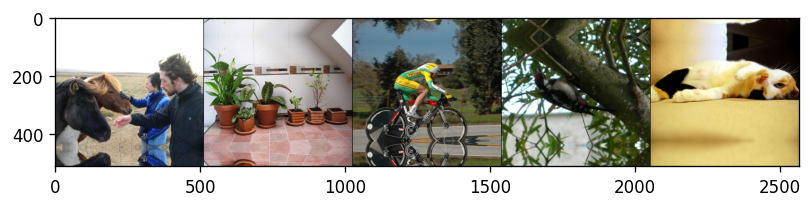

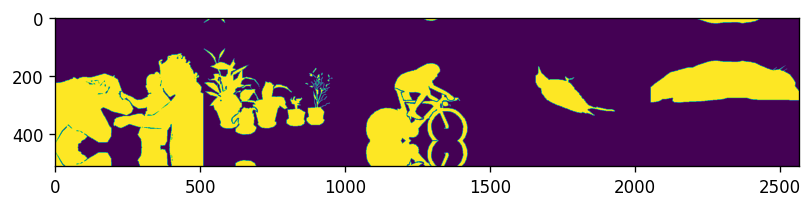

With paddng


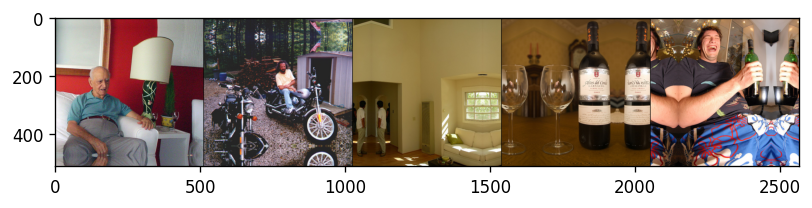

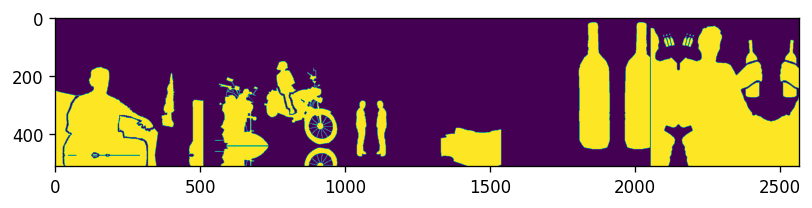

In [10]:
def show_dataset(dataset):
    images = []
    masks = []
    for _ in range(5):
        i = random.randint(0, len(valset) - 1)
        if len(images):
            separator = np.zeros((dataset.image_size[0], 2, 3), dtype=np.uint8)
            images.append(separator)
            masks.append(separator[:, :, 0])
        image, mask = dataset[i]
        images.append(cvmade.image.image_to_numpy(image))
        masks.append(cvmade.image.image_to_numpy(mask[None, ...])[..., 0])

    set_figure_size()
    plt.imshow(np.concatenate(images, axis=1))
    plt.show()
    set_figure_size()
    plt.imshow(np.concatenate(masks, axis=1))
    plt.show()

print("Without padding")
valset.set_padding(0)
show_dataset(trainset)
print("With paddng")
valset.set_padding(40)
show_dataset(trainset)
valset.set_padding(0)

## Create model

Создадим сеть вида U-Net (https://arxiv.org/pdf/1505.04597.pdf).

Сеть U-Net состоит из двух частей. Первая часть строит эмбеддинг. Вторая часть зарисовывает изображение и имеет структуру, похожую на первую часть. Первая часть использует `max pooling` и сжимает изображение, а вторая разжимает за счёт транспонированной свёртки. Из-за этого возникает параллель между слоями первой и второй части: они имеют схожий размер тензоров. По этой причине мы можем использовать выходы слоёв первой части в качестве входов для слоёв второй части. Информация из первой части, в которой сохраняются небольшие детали изображения, без труда используется при зарисовке, что приводит к повышению детализации маски.

<img src="resources/example-image.jpg" align="left" hspace="20" width="20%" height="20%"/> 
<img src="resources/u-net.jpg" align="left" hspace="20" width="50%" height="50%"/> 
<img src="resources/example-mask.jpg" align="left" hspace="20" width="20%" height="20%"/> 
<div style="clear:both;"></div>

Почему сеть называется U-Net? ;)

Заметьте, что размер выходного тензора меньше, чем размер входного. В сети не используется паддинг, что позволяет сделать выход независящим от позиции на изображении. В оригинальной статье сеть используется для сегментации больших изображений методом скользящего окна. При этом на границе используется зеркальный паддинг, размер которого определяется рецептивным полем сети.

<img src="resources/unet-window.jpg" align="left" hspace="20" width="80%" height="80%"/> 
<div style="clear:both;"></div>

Мы внесём несколько изменений в U-Net для ускорения тренировки и повышения качества:
* будем использовать меньший размер изображений и меньший размер сети;
* добавим `residual connections`;
* добавим `batch normalization`.

Шпаргалка:

```python
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                groups=1, bias=True, padding_mode='zeros')

torch.nn.ReLU(inplace=False)

torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False,
                   ceil_mode=False)

torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0,
                         output_padding=0, groups=1, bias=True, dilation=1,
                         padding_mode='zeros')
```

In [11]:
def make_conv1x1(in_channels, out_channels):
    """Create 1x1 convolution layer."""
    layer = torch.nn.Conv2d(in_channels, out_channels, 1)
    return layer


def make_transposed_convolution2x2(in_channels, out_channels):
    """Create transposed convolution (deconvolution, upconvolution)."""

    # Note the output_padding parameter: since stride in maxpooling can give
    # the same output size for different input sizes, it is necessary
    # to specify such an addition to the dimentionality that the resulting
    # tensor has the same dimentions as in the first network part.
    #
    # Since we always have an even image size, output_padding must be set to 0.
    layer = torch.nn.ConvTranspose2d(
        in_channels, out_channels, 2, stride=2, output_padding=0
    )
    return layer


def make_conv3x3(in_channels, out_channels, bias=True):
    return torch.nn.Conv2d(in_channels, out_channels, 3, bias=bias)


def make_batchnorm(channels):
    return torch.nn.BatchNorm2d(channels)


def make_relu():
    return torch.nn.ReLU(inplace=True)


def make_maxpool2x2():
    return torch.nn.MaxPool2d(2)

In [12]:
seminar.check_conv1x1(make_conv1x1)
seminar.check_t_conv(make_transposed_convolution2x2)
seminar.check_ok()

CHECK OK


In [13]:
class ConvBlock(torch.nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            make_conv3x3(in_channels, out_channels, bias=False),
            make_batchnorm(out_channels),
            make_relu(),
            make_conv3x3(out_channels, out_channels, bias=False),
            make_batchnorm(out_channels),
            make_relu(),
        )


class ResConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.main_path = torch.nn.Sequential(
            make_conv3x3(in_channels, out_channels, bias=False),
            make_batchnorm(out_channels),
            make_relu(),
            make_conv3x3(out_channels, out_channels, bias=False),
            make_batchnorm(out_channels),
        )
        self.residual_path = make_conv1x1(in_channels, out_channels)
        self.last_relu = make_relu()

    def forward(self, x):
        result = self.main_path(x)
        residual = self.residual_path(x)[:, :, 2:-2, 2:-2]
        result = self.last_relu(result + residual)
        return result

In [14]:
# We implement two classes.
#
# UNetDown performs transformations between two max pooling layers and also
# starts with max pooling. The first two convolutions are not included.
#
# UNetUp performs transformations between two transposed convolutions
# and starts with transposed convolution. The last convolution in the network
# is non included.
#
# Model scheme:
# input -> conv -> conv -> Down x 4 -> Up x 4 -> conv -> output.


class UNetDown(torch.nn.Sequential):
    """The part between the two max poolings, starting with max pooling."""
    def __init__(self, in_channels, out_channels, block):
        layers = [make_maxpool2x2(), block(in_channels, out_channels)]
        super().__init__(*layers)


class UNetUp(torch.nn.Module):
    """
    The part between two transposed colvolutions, starting with
    transposed convolution.
    """
    def __init__(self, in_channels, out_channels, block):
        super().__init__()
        self._transposed_convolution = make_transposed_convolution2x2(
            in_channels, out_channels
        )
        self._convolutions = block(out_channels * 2, out_channels)

    def forward(self, x_down, x_up):
        x_up = self._transposed_convolution(x_up)

        b_down, c_down, h_down, w_down = x_down.shape
        b_up, c_up, h_up, w_up = x_up.shape
        if (h_up > h_down) or (w_up > w_down):
            raise ValueError("Up tensor must be smaller than down tensor.")
        offset = ((h_down - h_up) // 2, (w_down - w_up) // 2)
        x_down_cropped = x_down[
            :, :, offset[0] : offset[0] + h_up, offset[1] : offset[1] + w_up
        ]

        x = torch.cat((x_down_cropped, x_up), axis=1)
        result = self._convolutions(x)
        return result


class UNet(torch.nn.Module):
    def __init__(self, num_classes, num_scales=4, base_filters=64, block=ConvBlock):
        """
        Create U-Net model.

        Args:
            num_classes: the number of output classes; for object/background
                         classification 2 classes are required.
            num_scales: the number of U-Net blocks transforming image size.
            base_filters: the number of filters on the first net level.
        """
        super().__init__()
        self._input_convolutions = block(3, base_filters)

        layers = []
        filters = base_filters
        for i in range(num_scales):
            layers.append(UNetDown(filters, filters * 2, block))
            filters *= 2
        self._down_layers = torch.nn.Sequential(*layers)

        layers = []
        for i in range(num_scales):
            layers.append(UNetUp(filters, filters // 2, block))
            filters //= 2
        self._up_layers = torch.nn.Sequential(*layers)

        self._output_convolution = make_conv1x1(filters, num_classes)
        self.initialize_weights()

        # Let's evaluate how much the network shrinks the image:
        self.eval()
        sample_input = torch.zeros((1, 3, 1000, 1000))
        if USE_CUDA:
            sample_input = sample_input.cuda()
            self.cuda()
        with torch.no_grad():
            sample_output = self(sample_input)
        self.padding = (sample_input.shape[-1] - sample_output.shape[-1]) // 2

    def forward(self, x):
        down_results = [self._input_convolutions(x)]
        for layer in self._down_layers:
            down_results.append(layer(down_results[-1]))
        x = down_results[-1]
        for i, layer in enumerate(self._up_layers):
            x = layer(down_results[-2 - i], x)
        x = self._output_convolution(x)
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
                torch.nn.init.kaiming_normal_(
                    m.weight, mode="fan_out", nonlinearity="relu"
                )
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)


def count_parameters(model):
    total = 0
    for p in model.parameters():
        total += np.prod(list(p.shape))
    return total

In [15]:
USE_RESIDUALS = True

unet = UNet(
    NUM_CLASSES if NUM_CLASSES > 2 else 1,
    num_scales=4,  # The number of U-Net blocks; 4 in the article.
    base_filters=64,  # The size of conv on the first level; 64 in the article.
    block=ResConvBlock if USE_RESIDUALS else ConvBlock,
)

print(unet)
print(f"Required padding: {unet.padding}.")
print(f"Total parameters: {count_parameters(unet)}.")

UNet(
  (_input_convolutions): ResConvBlock(
    (main_path): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (residual_path): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (last_relu): ReLU(inplace=True)
  )
  (_down_layers): Sequential(
    (0): UNetDown(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ResConvBlock(
        (main_path): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), 

## Train model

Создадим класс для подсчёта функции потерь — бинарной перекрёстной энтропии.

In [16]:
def crop_images(predicted, masks_or_images):
    """
    If the output is larger or smaller than the original image,
    crop the central parts of both to match the sizes.
    """
    if len(masks_or_images.shape) == 3:
        predicted, masks = crop_images(predicted, masks_or_images.unsqueeze(1))
        return predicted, masks[:, 0]
    images = masks_or_images
    if (len(predicted.shape) != 4) or (len(images.shape) != 4):
        raise ValueError("Expected tensors of shape BCHW")
    bi, ci, hi, wi = images.shape
    bp, cp, hp, wp = predicted.shape
    offset = (abs(hi - hp) // 2, abs(wi - wp) // 2)
    if hp < hi:
        images = images[:, :, offset[0] : offset[0] + hp]
    else:
        predicted = predicted[:, :, offset[0] : offset[0] + hi]
    if wp < wi:
        images = images[:, :, :, offset[1] : offset[1] + wp]
    else:
        predicted = predicted[:, :, :, offset[1] : offset[1] + wi]
    return predicted, images

Шпаргалка:

```python
torch.nn.BCEWithLogitsLoss(weight=None, size_average=None, reduce=None, reduction='mean',
                           pos_weight=None)
```

In [17]:
class BCELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self._bce = torch.nn.BCEWithLogitsLoss()

    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)
        b, c, h, w = predicted.shape
        if c != 1:
            raise ValueError(
                f"{type(self)} cannot be used for multiclass segmentation."
            )

        # predicted: float32, BCHW.
        # masks: long, BHW.
        loss = self._bce(predicted[:, 0], masks.float())
        return loss

In [18]:
seminar.check_bce_loss(BCELoss)
seminar.check_ok()

CHECK OK


In [19]:
class XentLoss(torch.nn.Module):
    """Loss function for multiclass segmentation."""
    def __init__(self):
        super().__init__()
        self._xent = torch.nn.CrossEntropyLoss()

    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)
        b, c, h, w = predicted.shape
        if c == 1:
            raise ValueError(
                f"{type(self)} cannot be used for multiclass segmentation."
            )
        predicted = predicted.permute(0, 2, 3, 1).reshape(b * h * w, c)
        masks = masks.reshape(-1)
        loss = self._xent(predicted, masks)
        return loss

In [20]:
def make_optimizer(model):
    return torch.optim.Adam(model.parameters(), lr=1e-4)

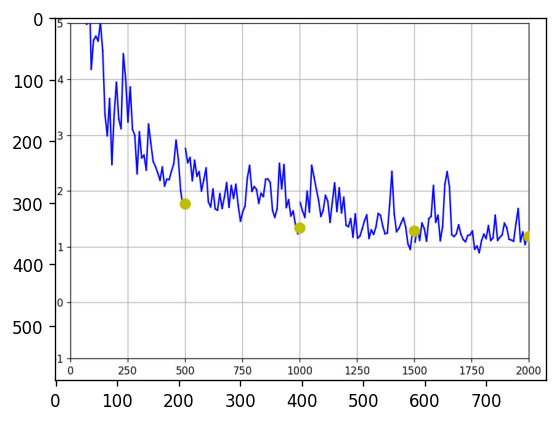

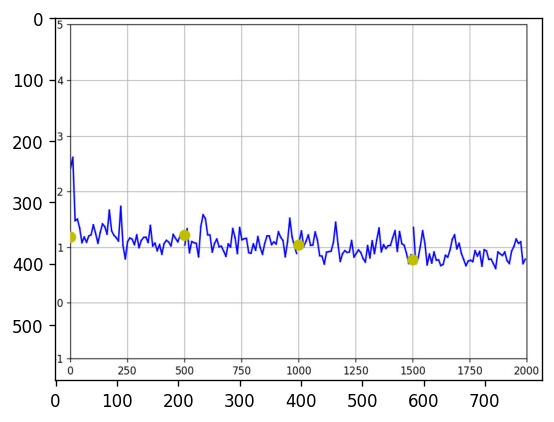

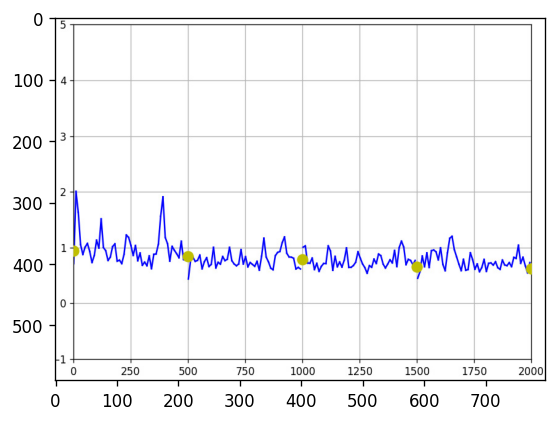

In [21]:
loss_fn = BCELoss if NUM_CLASSES == 2 else XentLoss

if TRAIN:
    # Enable interactive plots:
    %matplotlib notebook
    # trainset.set_padding(unet.padding)
    # valset.set_padding(unet.padding)
    seminar.train_model(unet, loss_fn, make_optimizer, trainset, valset,
                        lr_scheduler_fn=lambda opt: None,
                        n_iters=5000,
                        eval_steps=500,
                        batch_size=4,
                        num_workers=2,
                        init=False,
                        **TRAIN_KWARGS)
    # Disable interactive plots:
    %matplotlib inline
else:
    unet.load_state_dict(torch.load("checkpoint-noaug.pth.tar",
                                    map_location=device))
    cvmade.plot.show_image("resources/00-1-noaug.jpg")
    cvmade.plot.show_image("resources/00-2-noaug.jpg")
    cvmade.plot.show_image("resources/00-3-noaug.jpg")

In [22]:
# torch.save(unet.state_dict(), "checkpoint-noaug.pth.tar")

## Segmentations

In [23]:
def show_segmentations(model, dataset, n=5):
    model.eval()
    if USE_CUDA:
        model.cuda()
    for _ in range(n):
        image, mask_gt = dataset[random.randint(0, len(dataset) - 1)]
        if USE_CUDA:
            image = image.cuda()
            mask_gt = mask_gt.cuda()
        with torch.no_grad():
            predicted = model(image.unsqueeze(0))[0]  # CHW
            predicted, image = crop_images(predicted.unsqueeze(0),
                                           image.unsqueeze(0))
            predicted, image = predicted[0], image[0]
            c = predicted.shape[0]
            if c == 1:
                predicted = torch.nn.functional.logsigmoid(predicted)
                aggregated = predicted[0]
                predicted_labels = predicted[0] > np.log(0.5)
            else:
                predicted = torch.nn.functional.log_softmax(predicted, 0)
                aggregated = torch.logsumexp(predicted[1:], axis=0)
                predicted_labels = predicted.max(0)[1]
        aggregated = aggregated.cpu().numpy()
        predicted_labels = predicted_labels.cpu().numpy().astype(np.uint8)
        image = cvmade.image.image_to_numpy(image)
        mask = (predicted_labels > 0)[..., None]
        selected = image * mask + 255 * (1 - mask)

        if c != 1:
            print("Classes:",
                  [LABELS[i] for i in set(predicted_labels.flatten().tolist())])
        set_figure_size()
        fig, axs = plt.subplots(1, 4, figsize=(12, 6))
        axs[0].imshow(image)
        axs[1].imshow(predicted_labels)
        axs[2].imshow(aggregated)
        axs[3].imshow(selected)
        plt.show()

Trainset


<Figure size 960x720 with 0 Axes>

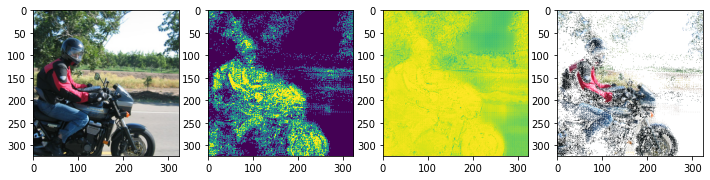

<Figure size 960x720 with 0 Axes>

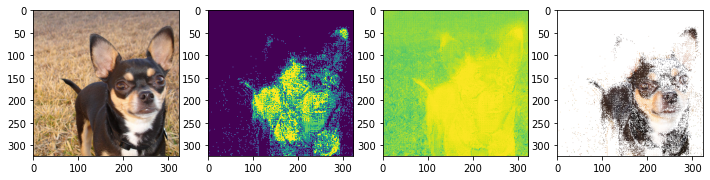

<Figure size 960x720 with 0 Axes>

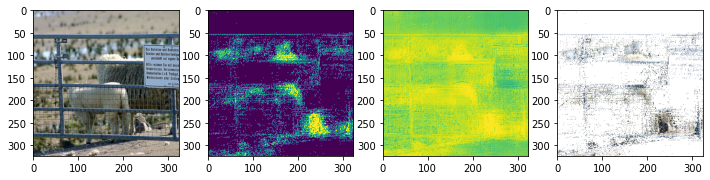

<Figure size 960x720 with 0 Axes>

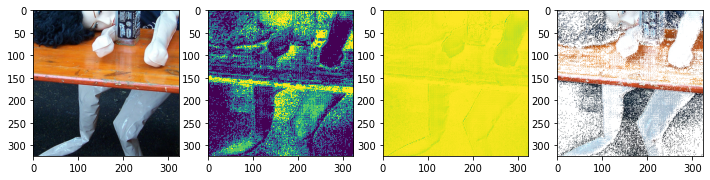

<Figure size 960x720 with 0 Axes>

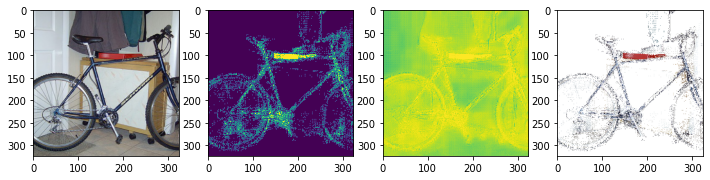

Valset


<Figure size 960x720 with 0 Axes>

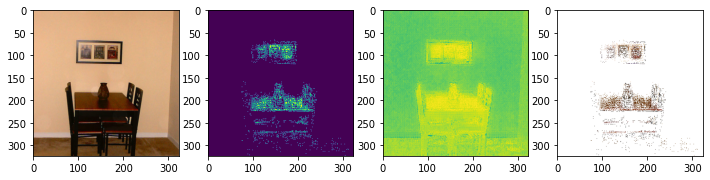

<Figure size 960x720 with 0 Axes>

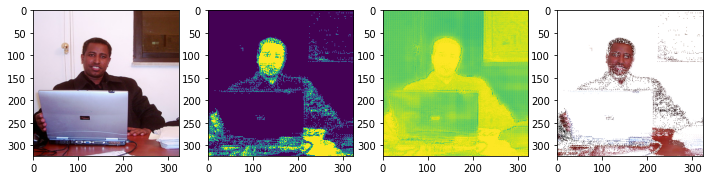

<Figure size 960x720 with 0 Axes>

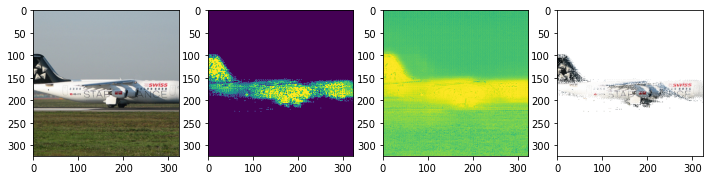

<Figure size 960x720 with 0 Axes>

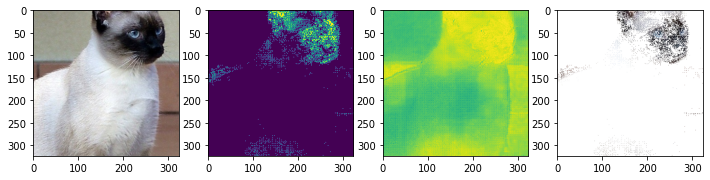

<Figure size 960x720 with 0 Axes>

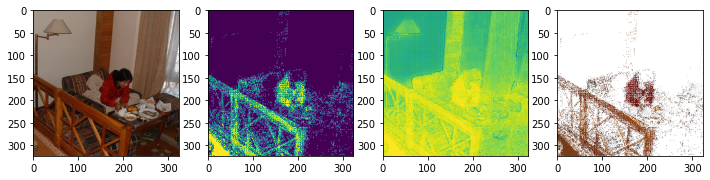

In [24]:
print("Trainset")
show_segmentations(unet, trainset)

print("Valset")
show_segmentations(unet, valset)

## Augmenation

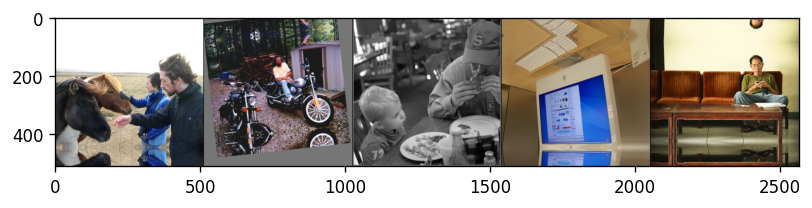

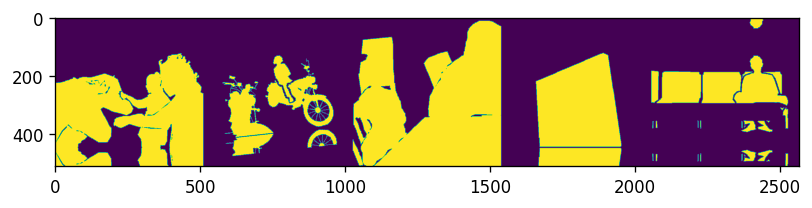

In [25]:
trainset_augmented = VOCDataset(
    DATA_ROOT,
    VOC_YEAR,
    (IMAGE_SIZE, IMAGE_SIZE),
    multiclass=MULTICLASS,
    train=True,
    augment=True,
)
show_dataset(trainset_augmented)

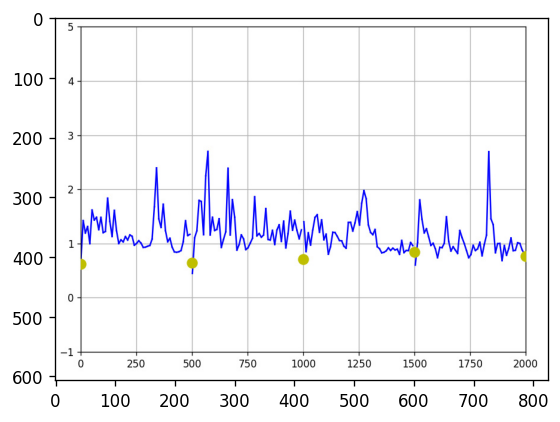

In [26]:
loss_fn = BCELoss if NUM_CLASSES == 2 else XentLoss

if TRAIN:
    # Enable interactive plots:
    %matplotlib notebook
    trainset.set_padding(unet.padding)
    valset.set_padding(unet.padding)
    seminar.train_model(unet, loss_fn, make_optimizer, trainset_augmented,
                        valset, lr_scheduler_fn=lambda optimizer: None,
                        n_iters=2000,
                        eval_steps=500,
                        batch_size=4,
                        num_workers=8,
                        init=False,
                        **TRAIN_KWARGS)
    # Disable interactive plots:
    %matplotlib inline
else:
    unet.load_state_dict(torch.load("checkpoint-aug.pth.tar",
                                    map_location=device))
    cvmade.plot.show_image("resources/01-1-aug.jpg")

In [27]:
# torch.save(unet.state_dict(), "checkpoint-aug.pth.tar")

Trainset


<Figure size 960x720 with 0 Axes>

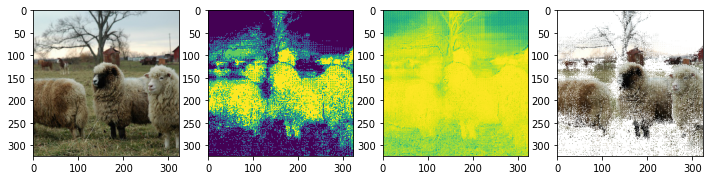

<Figure size 960x720 with 0 Axes>

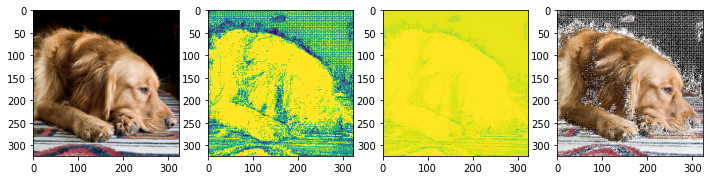

<Figure size 960x720 with 0 Axes>

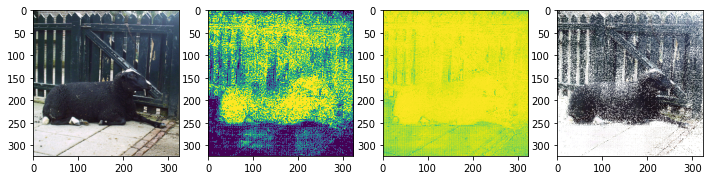

<Figure size 960x720 with 0 Axes>

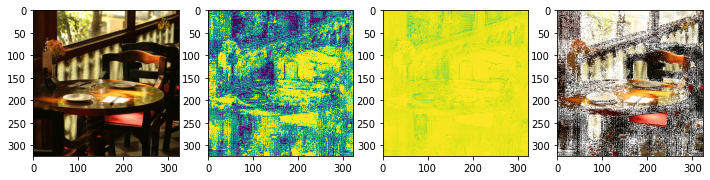

<Figure size 960x720 with 0 Axes>

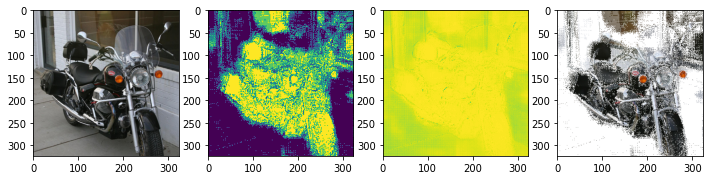

Valset


<Figure size 960x720 with 0 Axes>

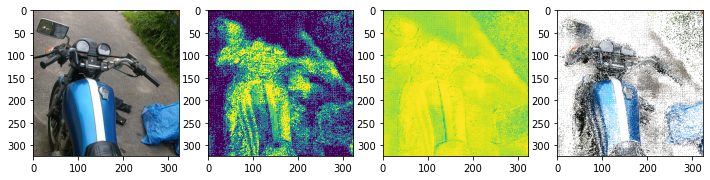

<Figure size 960x720 with 0 Axes>

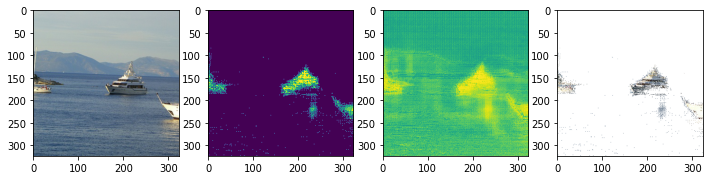

<Figure size 960x720 with 0 Axes>

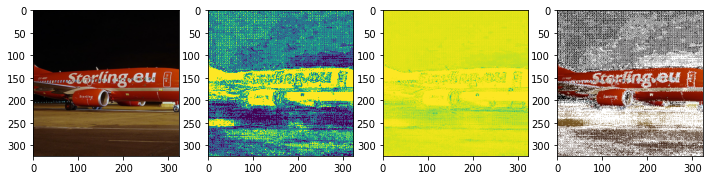

<Figure size 960x720 with 0 Axes>

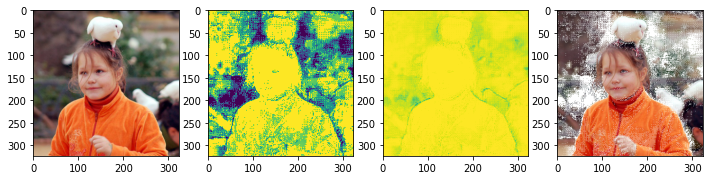

<Figure size 960x720 with 0 Axes>

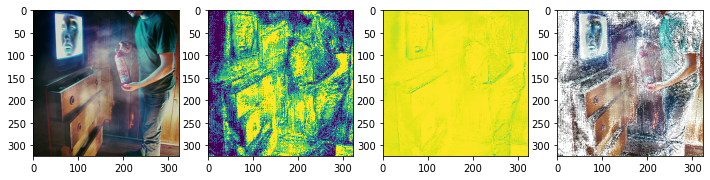

In [28]:
print("Trainset")
show_segmentations(unet, trainset)

print("Valset")
show_segmentations(unet, valset)

# Pretrained model

In [29]:
unet_pretrained = smp.Unet(
    "resnet34",
    encoder_weights="imagenet",
    classes=NUM_CLASSES if NUM_CLASSES > 2 else 1
)

unet_pretrained.eval()
sample_input = torch.zeros((1, 3, 1024, 1024))
if USE_CUDA:
    sample_input = sample_input.cuda()
    unet_pretrained.cuda()
with torch.no_grad():
    sample_output = unet_pretrained(sample_input)
pretrained_padding = (sample_input.shape[-1] - sample_output.shape[-1]) // 2
print(unet_pretrained)
print("Padding", pretrained_padding)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

## Segmentations before training

Trainset


<Figure size 960x720 with 0 Axes>

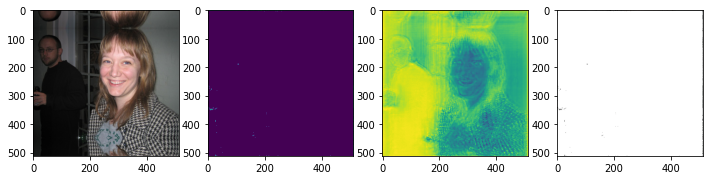

<Figure size 960x720 with 0 Axes>

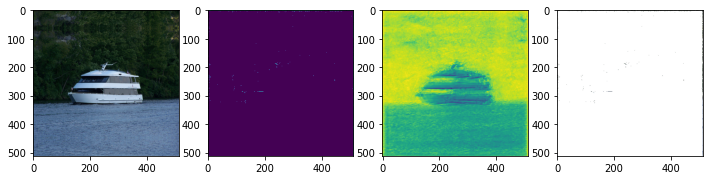

<Figure size 960x720 with 0 Axes>

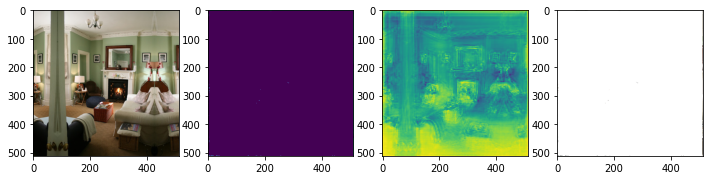

<Figure size 960x720 with 0 Axes>

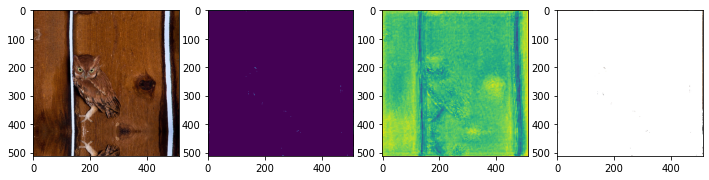

<Figure size 960x720 with 0 Axes>

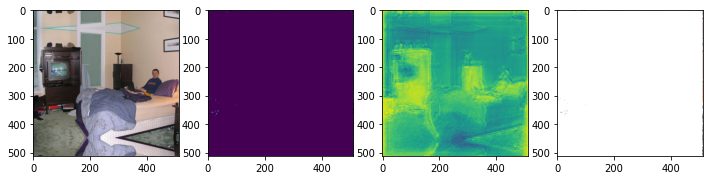

Valset


<Figure size 960x720 with 0 Axes>

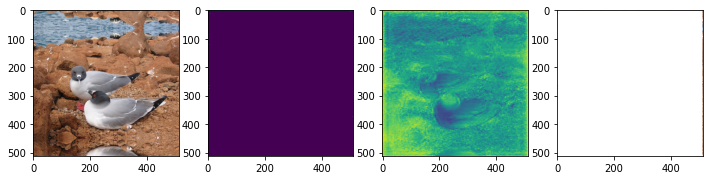

<Figure size 960x720 with 0 Axes>

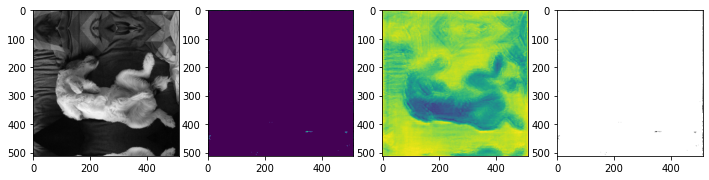

<Figure size 960x720 with 0 Axes>

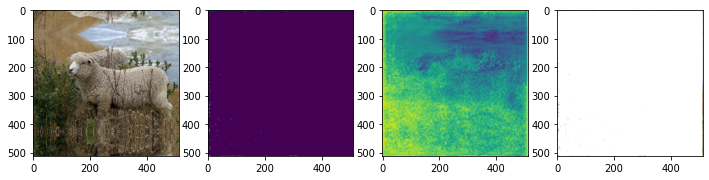

<Figure size 960x720 with 0 Axes>

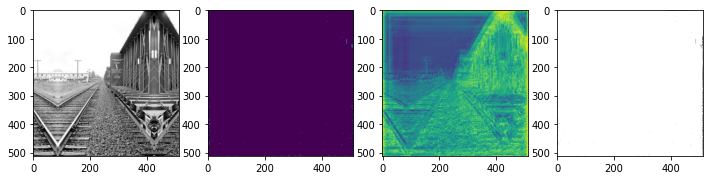

<Figure size 960x720 with 0 Axes>

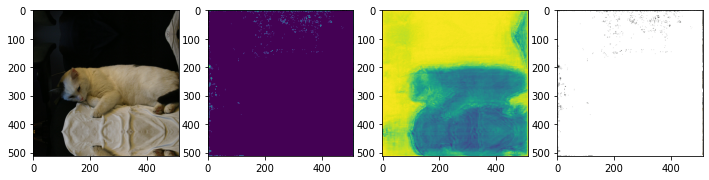

In [30]:
print("Trainset")
show_segmentations(unet_pretrained, trainset)

print("Valset")
show_segmentations(unet_pretrained, valset)

## Training

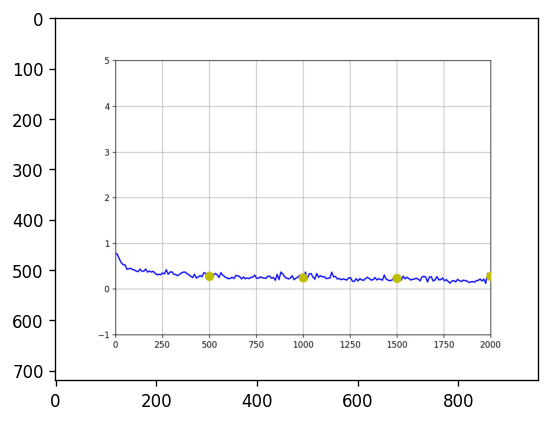

In [31]:
loss_fn = BCELoss if NUM_CLASSES == 2 else XentLoss

if TRAIN:
    # Enable interactive plots:
    %matplotlib notebook
    trainset.set_padding(pretrained_padding)
    valset.set_padding(pretrained_padding)
    seminar.train_model(unet_pretrained, loss_fn, make_optimizer, trainset,
                        valset, lr_scheduler_fn=lambda opt: None,
                        n_iters=2000,
                        eval_steps=500,
                        batch_size=4,
                        num_workers=8,
                        init=False,
                        **TRAIN_KWARGS)
    # Disable interactive plots:
    %matplotlib inline
else:
    unet_pretrained.load_state_dict(torch.load("checkpoint-pretrained.pth.tar",
                                               map_location=device))
    cvmade.plot.show_image("resources/02-pretrained.jpg")

In [32]:
# torch.save(unet_pretrained.state_dict(), "checkpoint-pretrained.pth.tar")

## Segmentations after training

Trainset


<Figure size 960x720 with 0 Axes>

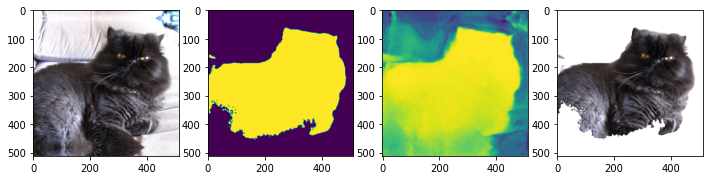

<Figure size 960x720 with 0 Axes>

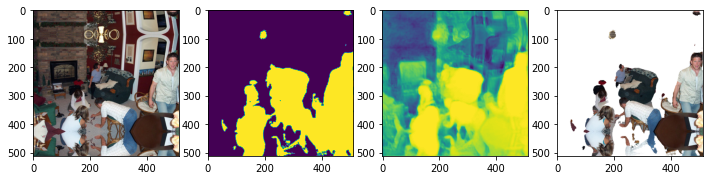

<Figure size 960x720 with 0 Axes>

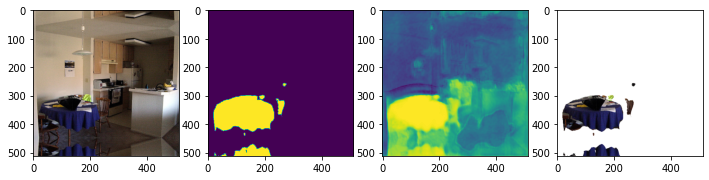

<Figure size 960x720 with 0 Axes>

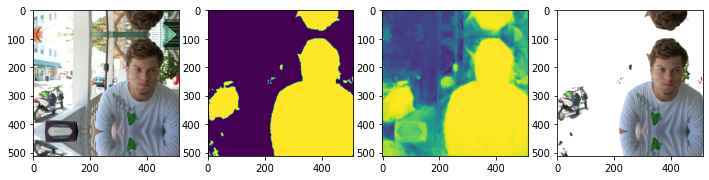

<Figure size 960x720 with 0 Axes>

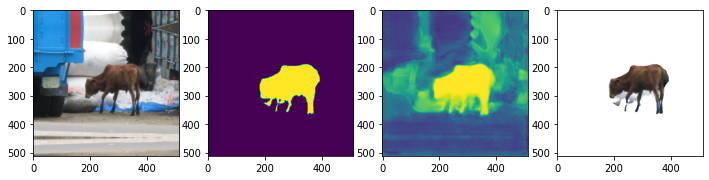

Valset


<Figure size 960x720 with 0 Axes>

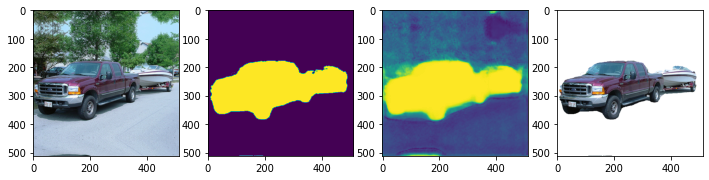

<Figure size 960x720 with 0 Axes>

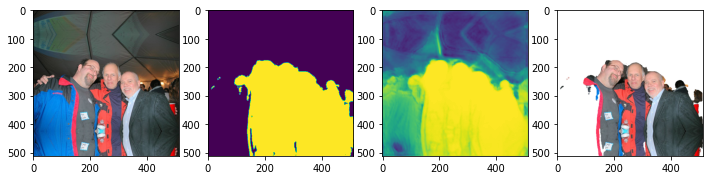

<Figure size 960x720 with 0 Axes>

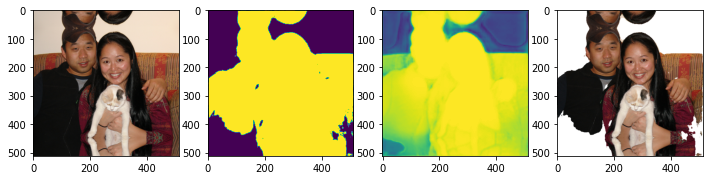

<Figure size 960x720 with 0 Axes>

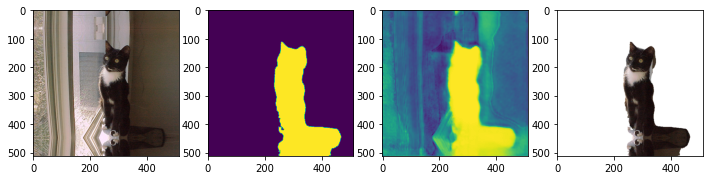

<Figure size 960x720 with 0 Axes>

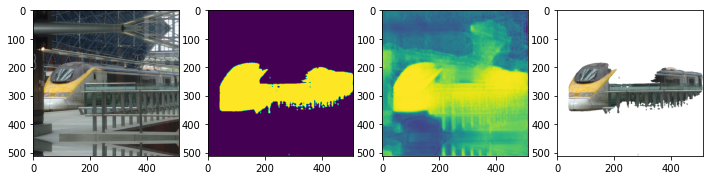

In [33]:
print("Trainset")
show_segmentations(unet_pretrained, trainset)

print("Valset")
show_segmentations(unet_pretrained, valset)